In [1]:
import pandas as pd
import nltk
import os
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
import kagglehub

path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

csv_file = os.path.join(path, "IMDB Dataset.csv")
df = pd.read_csv(csv_file)

df = df.sample(n=5000, random_state=42)  # Select exactly 5000 random rows

df.head()

100%|██████████| 25.7M/25.7M [00:00<00:00, 70.1MB/s]

Extracting files...


,review,sentiment
33553,I really liked this Summerslam due to the look...,positive
9427,Not many television shows appeal to quite as m...,positive
199,The film quickly gets to a major chase scene w...,negative
12447,Jane Austen would definitely approve of this o...,positive
39489,Expectations were somewhat high for me when I ...,negative


# 2. Data Preprocessing and Word Embeddings

In [3]:
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})
df["sentiment"] = df["sentiment"].astype(int)

df.head()

,review,sentiment
33553,I really liked this Summerslam due to the look...,1
9427,Not many television shows appeal to quite as m...,1
199,The film quickly gets to a major chase scene w...,0
12447,Jane Austen would definitely approve of this o...,1
39489,Expectations were somewhat high for me when I ...,0


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    tokens = word_tokenize(text.lower())  # Convert to lowercase
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

df["cleaned_review"] = df["review"].astype(str).apply(preprocess_text)

tokenized_reviews = df["cleaned_review"].tolist()

df.head()

,review,sentiment,cleaned_review
33553,I really liked this Summerslam due to the look...,1,"[really, liked, summerslam, due, look, arena, ..."
9427,Not many television shows appeal to quite as m...,1,"[many, television, show, appeal, quite, many, ..."
199,The film quickly gets to a major chase scene w...,0,"[film, quickly, get, major, chase, scene, ever..."
12447,Jane Austen would definitely approve of this o...,1,"[jane, austen, would, definitely, approve, one..."
39489,Expectations were somewhat high for me when I ...,0,"[expectation, somewhat, high, went, see, movie..."


## Train Word2Vec (CBOW & Skip-gram)

In [ ]:
from gensim.models import Word2Vec

tokenized_reviews = df["cleaned_review"].tolist()

cbow_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=2, sg=0)
skipgram_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=2, sg=1)

def get_sentence_word2vec_embedding(sentence, model, embedding_dim=100):
    embeddings = [model.wv[word] for word in sentence if word in model.wv]
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)
    return np.mean(embeddings, axis=0)

df["cbow_embedding"] = df["cleaned_review"].apply(lambda words: get_sentence_word2vec_embedding(words, cbow_model, 100))
df["skipgram_embedding"] = df["cleaned_review"].apply(lambda words: get_sentence_word2vec_embedding(words, skipgram_model, 100))

print(df[["cleaned_review", "cbow_embedding", "skipgram_embedding"]].head())

                                          cleaned_review  \
33553  [really, liked, summerslam, due, look, arena, ...   
9427   [many, television, show, appeal, quite, many, ...   
199    [film, quickly, get, major, chase, scene, ever...   
12447  [jane, austen, would, definitely, approve, one...   
39489  [expectation, somewhat, high, went, see, movie...   

                                          cbow_embedding  \
33553  [-0.18368062, 0.3297208, 0.18369937, -0.007124...   
9427   [-0.20671232, 0.3666829, 0.21843332, -0.039151...   
199    [-0.26385304, 0.39550886, 0.33371672, 0.056370...   
12447  [-0.20406145, 0.3666679, 0.18063304, -0.018039...   
39489  [-0.21038403, 0.3600785, 0.2595401, -0.0264305...   

                                      skipgram_embedding  
33553  [-0.077944234, 0.17649625, 0.055421583, -0.033...  
9427   [0.012318181, 0.14237955, 0.0715437, -0.067959...  
199    [-0.04719036, 0.13019702, 0.07489812, -0.06940...  
12447  [-0.030279763, 0.19004115, 0.022969

## Load Pretrained GloVe Embeddings

In [ ]:
import gensim.downloader as api

glove_model = api.load("glove-wiki-gigaword-100")

def get_sentence_glove_embedding(sentence, glove_model, embedding_dim=100):
    embeddings = [glove_model[word] for word in sentence if word in glove_model]
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)

    return np.mean(embeddings, axis=0)

df["glove_embedding"] = df["cleaned_review"].apply(lambda words: get_sentence_glove_embedding(words, glove_model, 100))

print(df[["cleaned_review", "glove_embedding"]].head())

[==================================================] 100.0% 128.1/128.1MB downloaded
                                          cleaned_review  \
33553  [really, liked, summerslam, due, look, arena, ...   
9427   [many, television, show, appeal, quite, many, ...   
199    [film, quickly, get, major, chase, scene, ever...   
12447  [jane, austen, would, definitely, approve, one...   
39489  [expectation, somewhat, high, went, see, movie...   

                                         glove_embedding  
33553  [0.04862384, 0.09076813, 0.23065777, -0.335847...  
9427   [-0.0729136, 0.2236684, 0.30613723, -0.0610111...  
199    [0.06027008, 0.12612863, 0.24536757, -0.189702...  
12447  [0.09296159, 0.04188319, 0.23490724, -0.250469...  
39489  [0.017898897, 0.15629151, 0.33750856, -0.23393...  


## Train FastText Model

In [ ]:
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

def get_sentence_fasttext_embedding(sentence, model, embedding_dim=300):
    embeddings = [model[word] for word in sentence if word in model]
    if len(embeddings) == 0:
        return np.zeros(embedding_dim)
    return np.mean(embeddings, axis=0)

df["fasttext_embedding"] = df["cleaned_review"].apply(lambda words: get_sentence_fasttext_embedding(words, fasttext_model, 300))

print(df[["cleaned_review", "fasttext_embedding"]].head())

[==================================================] 100.0% 958.5/958.4MB downloaded
                                          cleaned_review  \
33553  [really, liked, summerslam, due, look, arena, ...   
9427   [many, television, show, appeal, quite, many, ...   
199    [film, quickly, get, major, chase, scene, ever...   
12447  [jane, austen, would, definitely, approve, one...   
39489  [expectation, somewhat, high, went, see, movie...   

                                      fasttext_embedding  
33553  [-0.005416828, -0.014758672, 0.019399552, 0.03...  
9427   [-0.0078932615, -0.009920256, 0.01065052, 0.01...  
199    [-0.009155359, 0.0067492663, -0.0013296425, 0....  
12447  [-0.009996403, -0.013863154, 0.014329304, 0.01...  
39489  [-0.01203623, -0.0008441766, 0.0076729963, 0.0...  


## Evaluate embeddings

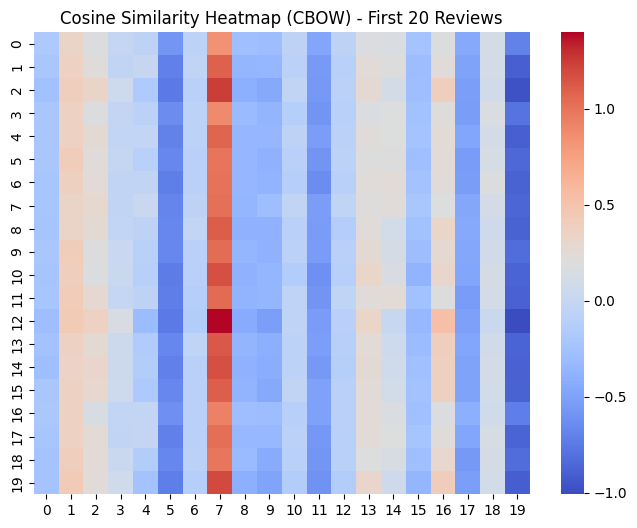

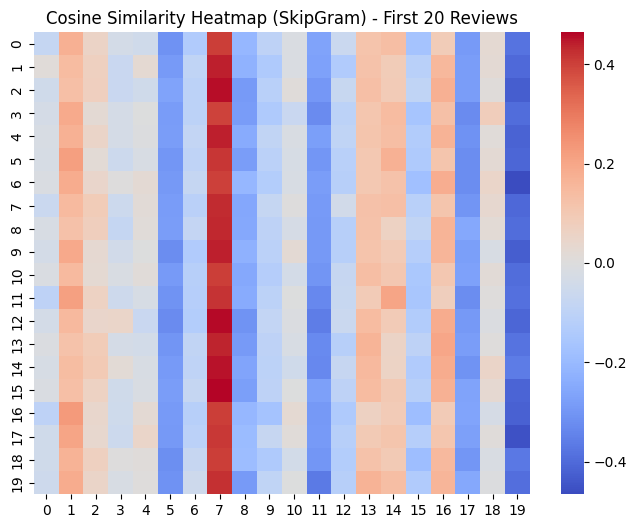

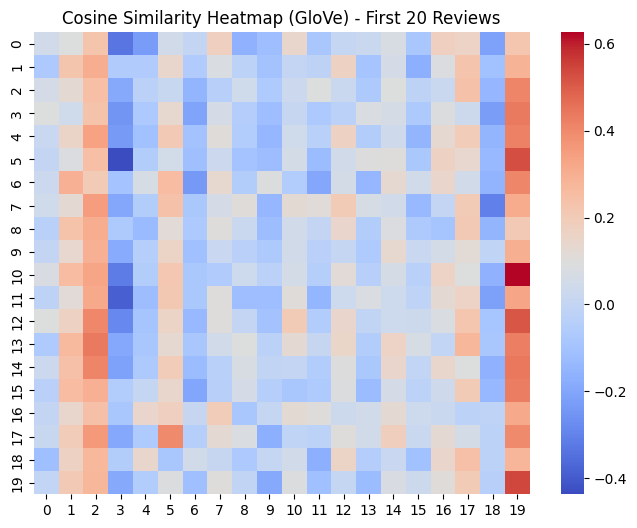

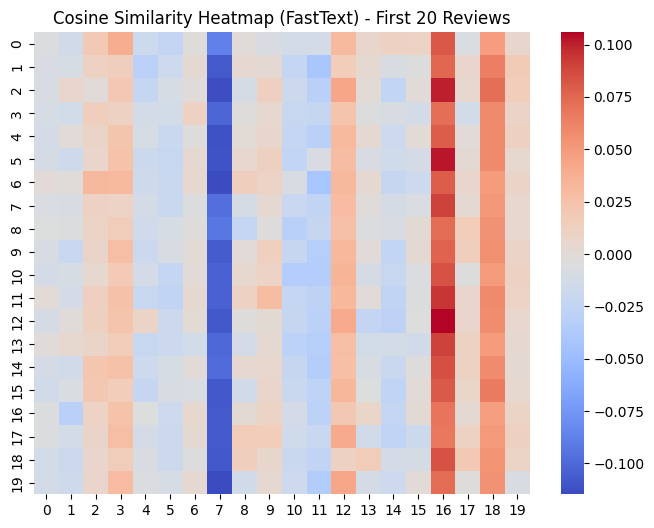

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

embedding_columns = ["fasttext_embedding", "glove_embedding", "cbow_embedding", "skipgram_embedding"]

for col in embedding_columns:
    df[col] = df[col].apply(lambda x: np.array(x) if isinstance(x, list) else x)

def plotSimilarityMatrix(cosine_sim_matrix, chosen_embedding):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cosine_sim_matrix[:20, :20], cmap="coolwarm", annot=False)
    plt.title(f"Cosine Similarity Heatmap ({chosen_embedding}) - First 20 Reviews")
    plt.show()

# Compute Cosine Similarity Matrix for a chosen embedding type
embedding_matrix_cbow = np.stack(df['cbow_embedding'].values)
cosine_sim_matrix_cbow = cosine_similarity(embedding_matrix_cbow)

embedding_matrix_skipgram = np.stack(df['skipgram_embedding'].values)
cosine_sim_matrix_skipgram = cosine_similarity(embedding_matrix_skipgram)

embedding_matrix_glove = np.stack(df['glove_embedding'].values)
cosine_sim_matrix_glove = cosine_similarity(embedding_matrix_glove)

embedding_matrix_fasttext = np.stack(df['fasttext_embedding'].values)
cosine_sim_matrix_fasttext = cosine_similarity(embedding_matrix_fasttext)

plotSimilarityMatrix(embedding_matrix_cbow, 'CBOW')
plotSimilarityMatrix(embedding_matrix_skipgram, 'SkipGram')
plotSimilarityMatrix(embedding_matrix_glove, 'GloVe')
plotSimilarityMatrix(embedding_matrix_fasttext, 'FastText')

## Visualize Embeddings Using PCA

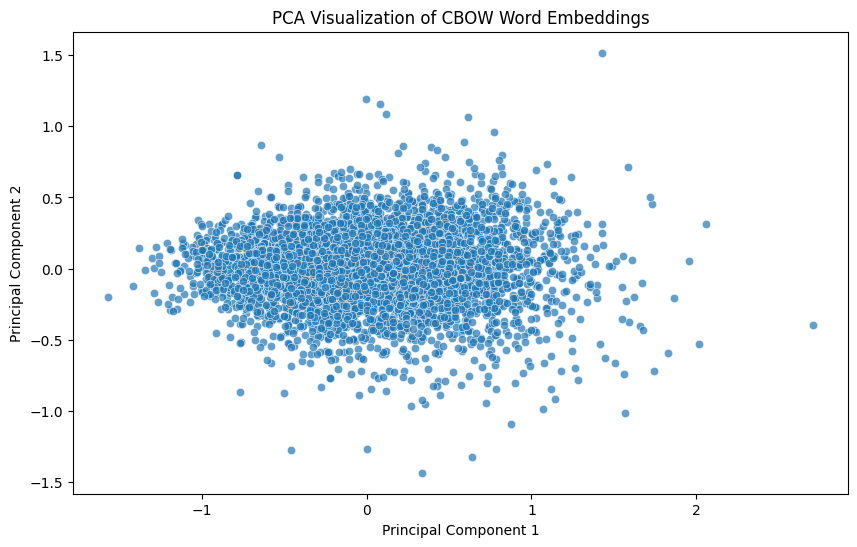

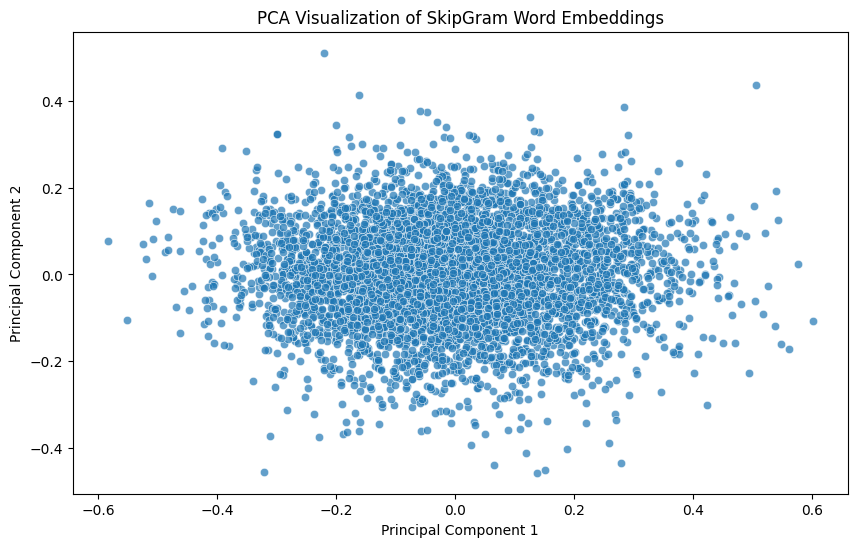

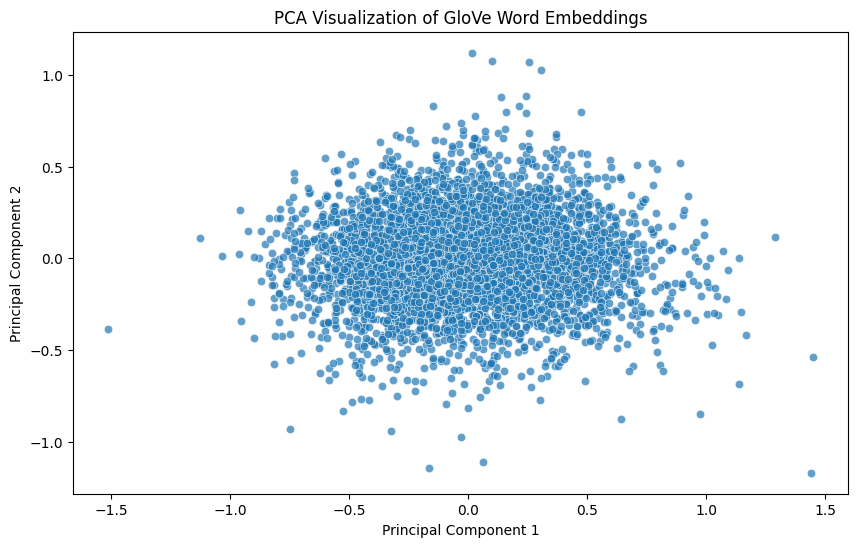

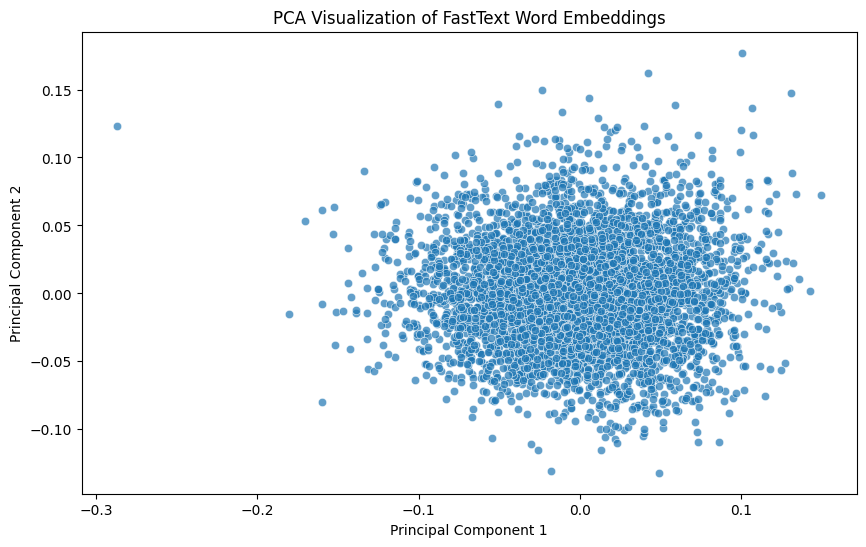

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings_cbow = pca.fit_transform(embedding_matrix_cbow)
pca_embeddings_skipgram = pca.fit_transform(embedding_matrix_skipgram)
pca_embeddings_glove = pca.fit_transform(embedding_matrix_glove)
pca_embeddings_fasttext = pca.fit_transform(embedding_matrix_fasttext)

def plotWordEmbeddings(pca_embeddings, chosen_embedding):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1], alpha=0.7)
    plt.title(f"PCA Visualization of {chosen_embedding} Word Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

plotWordEmbeddings(pca_embeddings_cbow, 'CBOW')
plotWordEmbeddings(pca_embeddings_skipgram, 'SkipGram')
plotWordEmbeddings(pca_embeddings_glove, 'GloVe')
plotWordEmbeddings(pca_embeddings_fasttext, 'FastText')

# 3.Recurrent Neural Networks for Sentiment Analysis

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [23]:
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_review"])
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(df["cleaned_review"])

padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df["sentiment"].values, test_size=0.2, random_state=42
)

print("Vocabulary size:", vocab_size)
print("Shape of padded sequences:", padded_sequences.shape)
print("Training set size:", X_train.shape, "Test set size:", X_test.shape)

Vocabulary size: 34015
Shape of padded sequences: (5000, 100)
Training set size: (4000, 100) Test set size: (1000, 100)


In [ ]:
# Model Parameters
EMBEDDING_DIM = 100  # Size of word embedding vectors
RNN_UNITS = 64  # Number of units in the RNN layer

# Build RNN Model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SimpleRNN(RNN_UNITS, activation="tanh"),
    Dense(1, activation="sigmoid")  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display Model Summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training Parameters
EPOCHS = 10
BATCH_SIZE = 32

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4792 - loss: 0.7028 - val_accuracy: 0.5010 - val_loss: 0.6944
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7321 - loss: 0.5877 - val_accuracy: 0.4930 - val_loss: 0.7557
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8100 - loss: 0.3805 - val_accuracy: 0.5000 - val_loss: 0.8210
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8660 - loss: 0.2948 - val_accuracy: 0.5200 - val_loss: 0.8316
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9263 - loss: 0.1955 - val_accuracy: 0.5240 - val_loss: 0.9987
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9821 - loss: 0.0696 - val_accuracy: 0.5050 - val_loss: 1.1356
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9817 - loss: 0.0663 - val_accuracy: 0.5270 - val_loss: 0.9994
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9470 - loss: 0.1445 - val_accu

## Plot Model Training Curves (Accuracy & Loss)

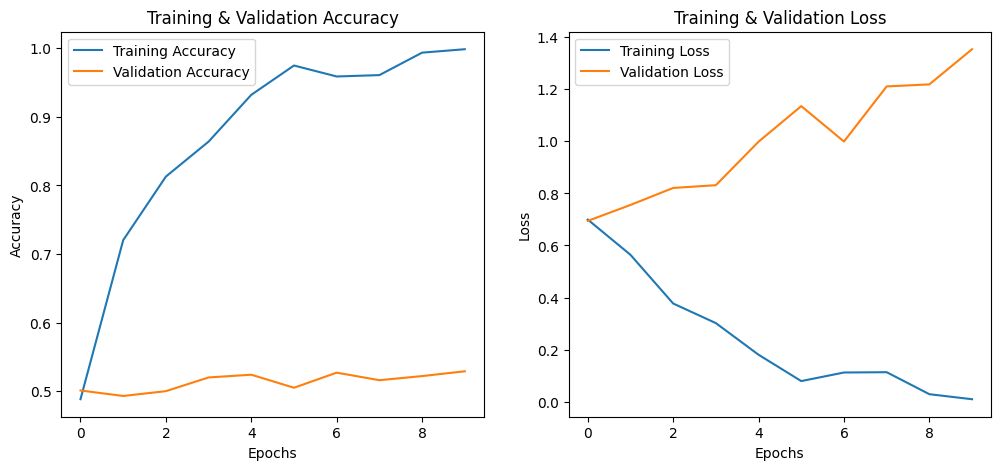

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

plt.show()

## Demonstrate Vanishing Gradient Problem

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


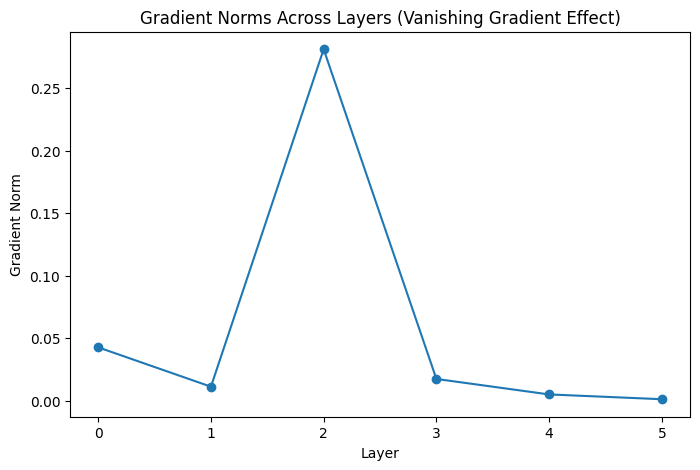

In [ ]:
# Function to compute gradient norms
def get_gradients(model, X, y):
    with tf.GradientTape() as tape:
        y_pred = model(X, training=True)  # Forward pass
        loss = model.compiled_loss(y, y_pred)  # Compute loss

    gradients = tape.gradient(loss, model.trainable_variables)  # Compute gradients
    grad_norms = [tf.norm(g).numpy() for g in gradients if g is not None]  # Compute norm

    return grad_norms

# Compute gradient norms for a batch
sample_X, sample_y = X_train[:32], y_train[:32]  # Take a small batch
gradient_norms = get_gradients(model, sample_X, sample_y)

# Plot Gradient Norms
plt.figure(figsize=(8, 5))
plt.plot(range(len(gradient_norms)), gradient_norms, marker="o")
plt.xlabel("Layer")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms Across Layers (Vanishing Gradient Effect)")
plt.show()

# 4. LSTM vs GRU

## LSTM model

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compile LSTM Model
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print Model Summary
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5021 - loss: 0.6945 - val_accuracy: 0.5130 - val_loss: 0.6924
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5849 - loss: 0.6921 - val_accuracy: 0.5290 - val_loss: 0.6894
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6615 - loss: 0.6370 - val_accuracy: 0.6300 - val_loss: 0.6740
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7398 - loss: 0.5371 - val_accuracy: 0.6890 - val_loss: 0.6247
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7827 - loss: 0.4909 - val_accuracy: 0.5850 - val_loss: 0.6693
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6954 - loss: 0.5468 - val_accuracy: 0.6480 - val_loss: 0.6566
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7496 - loss: 0.5042 - val_accuracy: 0.6120 - val_loss: 0.7294
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8149 - loss: 0.4044 - val_accu

## GRU model

In [ ]:
from tensorflow.keras.layers import GRU

# Define GRU Model
gru_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=MAX_SEQUENCE_LENGTH),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

# Compile GRU Model
gru_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print Model Summary
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5020 - loss: 0.6944 - val_accuracy: 0.5040 - val_loss: 0.6927
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5797 - loss: 0.6823 - val_accuracy: 0.5180 - val_loss: 0.6929
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6618 - loss: 0.6376 - val_accuracy: 0.6800 - val_loss: 0.6771
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8072 - loss: 0.4098 - val_accuracy: 0.7400 - val_loss: 0.6028
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9410 - loss: 0.1854 - val_accuracy: 0.7180 - val_loss: 0.7005
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9856 - loss: 0.0527 - val_accuracy: 0.7300 - val_loss: 0.8702
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9956 - loss: 0.0248 - val_accuracy: 0.7130 - val_loss: 1.1152
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9969 - loss: 0.0122 - val_accu

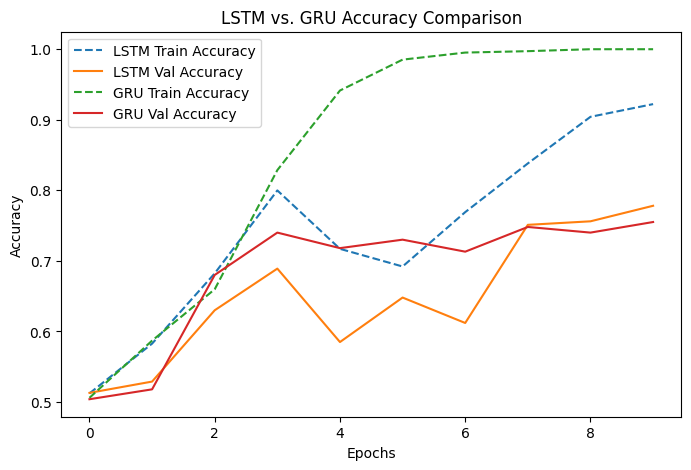

In [ ]:
# Extract accuracy values
lstm_acc = history_lstm.history["accuracy"]
lstm_val_acc = history_lstm.history["val_accuracy"]
gru_acc = history_gru.history["accuracy"]
gru_val_acc = history_gru.history["val_accuracy"]

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(lstm_acc, label="LSTM Train Accuracy", linestyle="dashed")
plt.plot(lstm_val_acc, label="LSTM Val Accuracy", linestyle="solid")
plt.plot(gru_acc, label="GRU Train Accuracy", linestyle="dashed")
plt.plot(gru_val_acc, label="GRU Val Accuracy", linestyle="solid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("LSTM vs. GRU Accuracy Comparison")
plt.show()

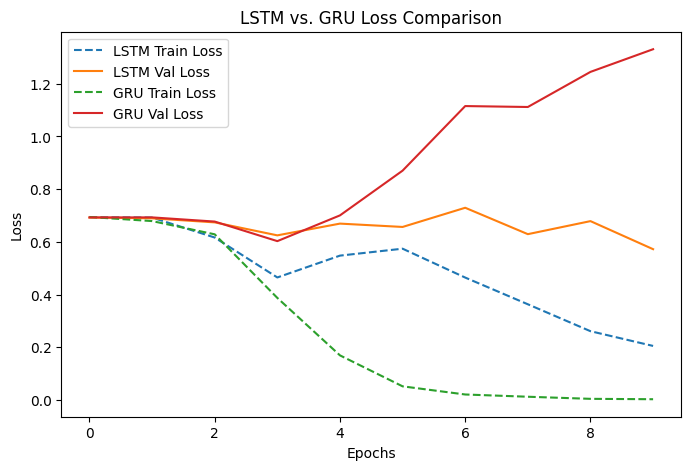

In [ ]:
# Extract loss values
lstm_loss = history_lstm.history["loss"]
lstm_val_loss = history_lstm.history["val_loss"]
gru_loss = history_gru.history["loss"]
gru_val_loss = history_gru.history["val_loss"]

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(lstm_loss, label="LSTM Train Loss", linestyle="dashed")
plt.plot(lstm_val_loss, label="LSTM Val Loss", linestyle="solid")
plt.plot(gru_loss, label="GRU Train Loss", linestyle="dashed")
plt.plot(gru_val_loss, label="GRU Val Loss", linestyle="solid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("LSTM vs. GRU Loss Comparison")
plt.show()

In [ ]:
# Get final epoch accuracy
final_lstm_acc = history_lstm.history["val_accuracy"][-1]
final_gru_acc = history_gru.history["val_accuracy"][-1]

print(f"Final LSTM Validation Accuracy: {final_lstm_acc:.4f}")
print(f"Final GRU Validation Accuracy: {final_gru_acc:.4f}")

Final LSTM Validation Accuracy: 0.7780
Final GRU Validation Accuracy: 0.7550


# Improving Performance with Bidirectional LSTM


In [13]:
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 400
EMBEDDING_DIM = 32

# Assume df["cleaned_review"] is tokenized text data
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df["cleaned_review"])

X = tokenizer.texts_to_sequences(df["cleaned_review"])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = df["sentiment"].values

In [15]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
# Define and train BiLSTM model
model = Sequential(name="Bidirectional_LSTM")
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM))
model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=False)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer=Adam(clipnorm=1.0), metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(X_valid, y_valid))

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5225 - loss: 0.6898 - val_accuracy: 0.7700 - val_loss: 0.5991
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8097 - loss: 0.4728 - val_accuracy: 0.8225 - val_loss: 0.3998
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9141 - loss: 0.2440 - val_accuracy: 0.8250 - val_loss: 0.4132
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9622 - loss: 0.1348 - val_accuracy: 0.8363 - val_loss: 0.4967
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9696 - loss: 0.0959 - val_accuracy: 0.8213 - val_loss: 0.5327


Bidirectional LSTM Score--->  [0.5874946713447571, 0.8029999732971191]


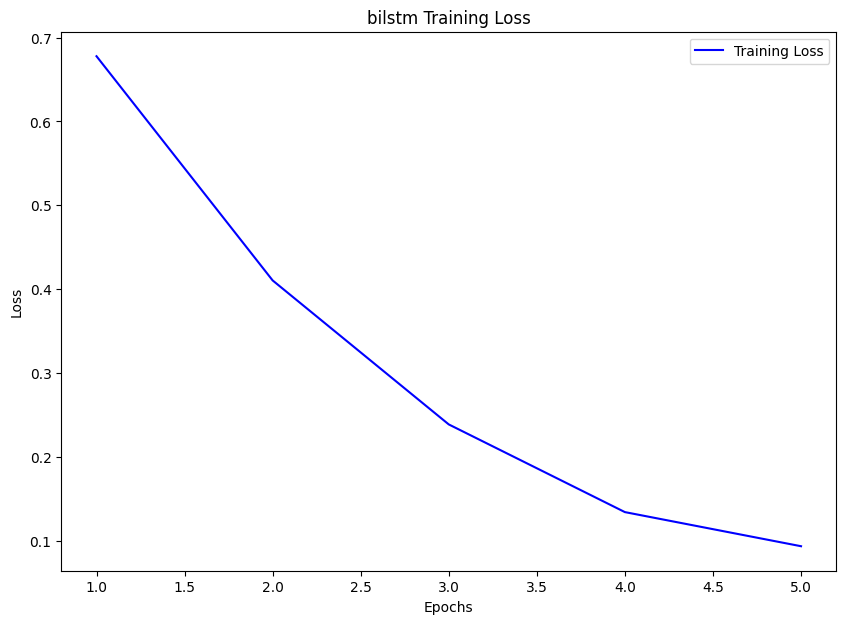

In [19]:
# Evaluate and plot results
print("Bidirectional LSTM Score---> ", model.evaluate(X_test, y_test, verbose=0))

def plot_loss(history, model_name=''):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure(figsize=(10, 7))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{model_name}_loss.png')

plot_loss(history, 'bilstm')